In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import nibabel as nib
from scipy.interpolate import RegularGridInterpolator as rgi

In [28]:
def get_labels(annotations_path):
    """
    Obtains Labels associated with vertices of the annotations file

    Parameters:
    - path: Anotations file path

    Returns:
    - labels: list of labels for each vertex
    """
    annot_data = nib.freesurfer.io.read_annot(annotations_path)
    labels = annot_data[0]
    return labels

def compute_extmat(mesh):
    """
    Compute the external transformation matrix (extmat) for a 3D mesh.

    This function calculates the external transformation matrix `extmat` for
    a 3D mesh, which can be used for various transformations such as centering
    and scaling the mesh.

    Parameters:
    - mesh (o3d.t.geometry.TriangleMesh): The 3D triangle mesh to compute the
      external transformation matrix for.

    Returns:
    - extmat (numpy.ndarray): A 4x4 transformation matrix represented as a
      NumPy array.
    """
    # Calculate the minimum and maximum corners of the mesh's bounding box.
    corner1 = np.min(mesh.vertex.positions.numpy(), axis=0)
    corner2 = np.max(mesh.vertex.positions.numpy(), axis=0)

    # Calculate the midpoint of the bounding box.
    midpoint = (corner1 + corner2) / 2

    # Create an identity 4x4 transformation matrix.
    extmat = np.eye(4)

    # Modify the diagonal elements and the last column of the matrix.
    np.fill_diagonal(extmat, [-1, 1, 1, 1])
    extmat[:,-1] = [-midpoint[0], -midpoint[1], -7.5 * corner1[2], 1]

    return extmat

def compute_intmat(img_width, img_height):
    """
    Compute the intrinsic matrix (intmat) for a camera with given image dimensions.

    Parameters:
    - img_width (int): The width of the camera image in pixels.
    - img_height (int): The height of the camera image in pixels.

    Returns:
    - intmat (numpy.ndarray): A 3x3 intrinsic matrix represented as a NumPy array.
    """
    # Create an identity 3x3 intrinsic matrix
    intmat = np.eye(3)

    # Fill the diagonal elements with appropriate values
    np.fill_diagonal(intmat, [-(img_width + img_height) / 1, -(img_width + img_height) / 1, 1])

    # Set the last column of the matrix for image centering
    intmat[:,-1] = [img_width / 2, img_height / 2, 1]

    return intmat

def create_mesh(mesh_path, perturb_vertices = True, std_dev = 0.1):
    """
    Create a 3D triangle mesh from a FreeSurfer surface file.

    This function reads a FreeSurfer surface file from the specified `mesh_path`,
    processes the vertex and face data, and constructs a 3D triangle mesh.

    Parameters:
    - mesh_path (str): The path to the FreeSurfer surface file to be processed.

    Returns:
    - mesh (o3d.t.geometry.TriangleMesh): A 3D triangle mesh representation of
      the input FreeSurfer surface.

    Dependencies: nibabel (nib), numpy (np), open3d (o3d)
    """
    # Read the FreeSurfer surface file and retrieve vertices, faces, and metadata.
    vertices, faces, info = nib.freesurfer.read_geometry(mesh_path, read_metadata=True)

    # Center the vertices around the origin.
    vertices = vertices - np.mean(vertices, axis=0)

    # Reorder the vertex columns for compatibility with open3d.
    vertices = vertices[:, [2, 0, 1]]

    # Create a 3D triangle mesh using open3d.
    mesh = o3d.t.geometry.TriangleMesh(o3d.core.Tensor(np.float32(vertices)),
                                       o3d.core.Tensor(np.int64(faces)))        
    
    # Compute vertex normals and triangle normals for the mesh.
    mesh.compute_vertex_normals()
    mesh.compute_triangle_normals()
    return vertices, faces, mesh

def generate_maps(mesh, labels, intmat, extmat, img_width, img_height, rotation_matrices, recompute_normals):
    """
    Generate the output map based on ray casting and mesh properties.
    views are in this order ALWAYS = ['Front', 'Bottom', 'Top', 'Right', 'Back', 'Left']

    Parameters:
    - mesh (o3d.t.geometry.TriangleMesh): The 3D triangle mesh to cast rays onto.
    - labels (numpy.ndarray): The labels associated with the vertices of the mesh.
    - intmat (numpy.ndarray): A 3x3 intrinsic matrix for camera calibration.
    - extmat (numpy.ndarray): A 4x4 external transformation matrix for camera pose.
    - img_width (int): The width of the camera image in pixels.
    - img_height (int): The height of the camera image in pixels.

    Returns:
    - output_maps(6, 1080, 1920, 3), labels_maps((6, 1080, 1920), ids_maps(6, 1080, 1920), vertex_maps(6, 1080, 1920,3)

    Notes:
    - This function performs ray casting on the provided mesh using the given
      camera parameters and computes an output map based on the cast rays.

    Example:
    >>> mesh = create_mesh("example_mesh.surf")
    >>> labels = get_labels(annotations_path)
    >>> intmat = compute_intmat(1920, 1080)
    >>> extmat = compute_extmat(mesh)
    >>> width = 1920
    >>> height = 1080
    >>> output_map, labels_map = generate_output_map(mesh, intmat, extmat, width, height)
    >>> print(output_map)
    >>> print(labels_map)

    """

    # Validate parameters using assert statements
    assert isinstance(mesh, o3d.t.geometry.TriangleMesh), "mesh should be of type o3d.t.geometry.TriangleMesh"
    assert isinstance(labels, np.ndarray), "labels should be a 1-D NumPy array"
    expected_shape = (mesh.vertex.normals.shape[0],)
    assert labels.shape == expected_shape, f"labels should have the shape {expected_shape} which is the number of vertices, but got {labels.shape}"    
    assert isinstance(intmat, np.ndarray) and intmat.shape == (3, 3), "intmat should be a 3x3 NumPy array"
    # assert isinstance(extmat, np.ndarray) and (extmat.shape == (1, 4, 4) or extmat.shape == (6, 4, 4)), "extmat should be a 4x4 or 6x4x4 NumPy array"
    assert isinstance(img_width, int) and img_width > 0, "img_width should be a positive integer"
    assert isinstance(img_height, int) and img_height > 0, "img_height should be a positive integer"

    # Create a RaycastingScene and add the mesh to it
    # Assuming 'View' argument will never be 'All':
    if recompute_normals == True:
        mesh.vertex.normals = mesh.vertex.normals@np.transpose(rotation_matrices[0][:3,:3].astype(np.float32))
        mesh.triangle.normals = mesh.triangle.normals@np.transpose(rotation_matrices[0][:3,:3].astype(np.float32))
        
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(mesh)

    output_maps = []
    labels_maps = []
    ids_maps = []
    vertex_maps = []

    # rotation_matrices = compute_rotations(random_degs=7, view = view) # Given as an argument
    for i in range(rotation_matrices.shape[0]): # TO DO - DONE: ROTATION MATRICES IS NOT DEFINED INSIDE THIS FUNCTION
        # Create rays using pinhole camera model
        rays = scene.create_rays_pinhole(intmat, extmat[i], img_width, img_height)
    
        # Cast rays and retrieve primitive IDs, hit distances, and normals
        cast = scene.cast_rays(rays)
        ids_map = np.array(cast['primitive_ids'].numpy(), dtype=np.int32)
        ids_maps.append(ids_map)
        hit_map = np.array(cast['t_hit'].numpy(), dtype=np.float32)
        weights_map = np.array(cast['primitive_uvs'].numpy(), dtype=np.float32)
        missing_weight = 1 - np.sum(weights_map, axis=2, keepdims=True)
        label_ids = np.argmax(np.concatenate((weights_map, missing_weight), axis=2), axis=2)
        
        # Compute the normal map
        normal_map = np.array(mesh.triangle.normals[ids_map.clip(0)].numpy(), dtype=np.float32)
        normal_map[ids_maps[i] == -1] = [0, 0, -1]
        normal_map[:, :, -1] = -normal_map[:, :, -1].clip(-1, 0)
        normal_map = normal_map * 0.5 + 0.5
    
        # Compute the vertex map
        vertex_map = np.array(mesh.triangle.indices[ids_map.clip(0)].numpy(), dtype=np.int32)
        vertex_map[ids_map == -1] = [-1]
        vertex_maps.append(vertex_map)
    
        # Compute the inverse distance map
        inverse_distance_map = 1 / hit_map
    
        # Compute the coded map with inverse distance
        coded_map_inv = normal_map * inverse_distance_map[:, :, None]
    
        # Normalize the output map
        output_map = (coded_map_inv - np.min(coded_map_inv)) / (np.max(coded_map_inv) - np.min(coded_map_inv))
        output_maps.append(output_map)
    
        # Compute the labels map
        labels_map = labels[vertex_map.clip(0)]
        labels_map[vertex_map == -1] = -1
        #labels_map = np.median(labels_map, axis=2)
        labels_map = labels_map[np.arange(labels_map.shape[0])[:, np.newaxis], np.arange(labels_map.shape[1]), label_ids]
        labels_map = labels_map.astype('float64')
        labels_maps.append(labels_map)

    output_maps = np.array(output_maps)
    labels_maps = np.array(labels_maps)
    #print('Type: ',labels_maps.dtype)
    # ids_maps = np.array(ids_maps)
    # vertex_maps = np.array(vertex_maps)
    
    return output_maps, labels_maps
    # return output_maps, labels_maps, ids_maps, vertex_maps

def compute_rotations(random_degs=5, view = 'Random', random = False):
    """
    Compute six random 3D rotation matrices for Front, Top, Bottom, Left, Back, Right views in this order
    with randomized small rotations from -3 to +3 degrees.

    Returns:
    - rotation_matrices (list of numpy.ndarray): A list containing six 4x4
      rotation matrices represented as NumPy arrays.

    Notes:
    - The rotation matrices are created based on random pitch and yaw angles
      with small random variations.
    """
    
    # Initialize an empty list to store the rotation matrices
    rotation_matrices = []

    if view == 'Random_6':
        # Select a random view from the available options
        available_views = ['Front', 'Bottom', 'Top', 'Right', 'Back', 'Left']
        view = np.random.choice(available_views)
        
    if view == 'All':
        # Define the pitch angles (Front, Bottom, Top) and add random variations
        pitch_angles = [0, 90, 270]
        pitch_angles = np.deg2rad(pitch_angles + np.random.uniform(-random_degs, random_degs, len(pitch_angles)))
        
        # Define the yaw angles (Right, Back, Left) and add random variations
        yaw_angles = [90, 180, 270]
        yaw_angles = np.deg2rad(yaw_angles + np.random.uniform(-random_degs, random_degs, len(yaw_angles)))
        
        # Loop through each pitch angle in radians and create the rotation matrix
        for angle in pitch_angles:
            R_pitch = create_pitch_rotation_matrix(angle)
            R = (R_pitch 
                 @ create_yaw_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
                 @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
            
            rotation_matrices.append(R)
            
        # Loop through each yaw angle in radians and create the rotation matrix
        for angle in yaw_angles:
            R_yaw = create_yaw_rotation_matrix(angle)
            R = (R_yaw 
                 @ create_pitch_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
                 @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
            rotation_matrices.append(R)

    elif view == 'Front': # Set this to recompute normals on the fly
        angle = np.deg2rad(np.random.uniform(-random_degs, random_degs))
        R = create_pitch_rotation_matrix(angle)
        R =  (create_pitch_rotation_matrix(angle)
             @ create_yaw_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)

    elif view == 'Bottom':
        angle = np.deg2rad(90 + np.random.uniform(-random_degs, random_degs))
        R =  (create_pitch_rotation_matrix(angle)
             @ create_yaw_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)

    elif view == 'Top':
        angle = np.deg2rad(270 + np.random.uniform(-random_degs, random_degs))
        R =  (create_pitch_rotation_matrix(angle)
             @ create_yaw_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)

    elif view == 'Right':
        angle = np.deg2rad(90 + np.random.uniform(-random_degs, random_degs))
        R = (create_yaw_rotation_matrix(angle) 
             @ create_pitch_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)

    elif view == 'Back':
        angle = np.deg2rad(180 + np.random.uniform(-random_degs, random_degs))
        R = (create_yaw_rotation_matrix(angle) 
             @ create_pitch_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)
    elif view == 'Left':
        angle = np.deg2rad(270 + np.random.uniform(-random_degs, random_degs))
        R = (create_yaw_rotation_matrix(angle) 
             @ create_pitch_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))) 
             @ create_roll_rotation_matrix(np.deg2rad(np.random.uniform(-random_degs, random_degs))))
        rotation_matrices.append(R)
        
    elif view == 'Random':
        R = (create_yaw_rotation_matrix(-np.pi + 2 * np.pi * np.random.rand()) 
             @ create_pitch_rotation_matrix(-np.pi + 2 * np.pi * np.random.rand()) 
             @ create_roll_rotation_matrix(-np.pi + 2 * np.pi * np.random.rand())) 
        rotation_matrices.append(R)
    rotation_matrices = np.array(rotation_matrices)
    
    #rotation_matrices = np.transpose(rotation_matrices, (1, 2, 0))

    return rotation_matrices

def create_pitch_rotation_matrix(pitch_angle):
    """
    Create a rotation matrix for pitch rotation.

    Parameters:
    - pitch_angle: Angle in radians for pitch rotation.

    Returns:
    - R_pitch: Rotation matrix for pitch.
    """
    R_pitch = np.array([[1, 0, 0, 0],
                        [0, np.cos(pitch_angle), -np.sin(pitch_angle), 0],
                        [0, np.sin(pitch_angle), np.cos(pitch_angle), 0],
                        [0, 0, 0, 1]])
    return R_pitch

def create_yaw_rotation_matrix(yaw_angle):
    """
    Create a rotation matrix for yaw rotation.

    Parameters:
    - yaw_angle: Angle in radians for yaw rotation.

    Returns:
    - R_yaw: Rotation matrix for yaw.
    """
    R_yaw = np.array([[np.cos(yaw_angle), 0, np.sin(yaw_angle), 0],
                      [0, 1, 0, 0],
                      [-np.sin(yaw_angle), 0, np.cos(yaw_angle), 0],
                      [0, 0, 0, 1]])
    return R_yaw

def create_roll_rotation_matrix(roll_angle):
    """
    Create a rotation matrix for roll rotation.

    Parameters:
    - roll_angle: Angle in radians for roll rotation.

    Returns:
    - R_roll: Rotation matrix for roll.
    """
    R_roll = np.array([[np.cos(roll_angle), -np.sin(roll_angle), 0, 0],
                       [np.sin(roll_angle), np.cos(roll_angle), 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])
    return R_roll

import gpytoolbox as gpy

def ray_mesh_intersect_2(R_V, rays, V, F, h, w, labels):
    """
    Find intersection points and intersected faces
    Work best with rand_ray

    Parameters
    ----------
    R_V
        Numpy array of vertices coordinates.

    rays
        Numpy array of the direction of rays shooting out of each vertex in R_V

    V
        Mesh's vertices' coordinates

    F
        Mesh's faces' vertices list

    Returns
    -------
    C_V
        numpy array of intersection points' coordinates
        
    intersected
        |F| array of 0 or 1 where 1 means this face is intersected with some rays.
    """
    ts, ids, _ = gpy.ray_mesh_intersect(R_V, rays, V, F)

    colors = [[] for _ in range(len(V))]
    # print(len(colors))
    # print(colors)

    for i, (t, id) in enumerate(zip(ts, ids)):
        if id != -1:
            # print(F[id])
            colors[F[id][0]].append(labels[i//w][i%w])
            colors[F[id][1]].append(labels[i//w][i%w])
            colors[F[id][2]].append(labels[i//w][i%w])

    return colors

def project_back_2(V, F, intmat, extmat, labels):
    R_V = []
    rays = []
    new_V = np.copy(V)
    for i in range(len(V)):
        new_V[i] = (extmat @ np.concatenate((np.array([V[i]]).T, np.array([[1]])))).flatten()[0:3]

    # corner1 = np.min(new_V, axis=0)
    # corner2 = np.max(new_V, axis=0)
    # print(corner1, corner2)

    h, w = len(labels), len(labels[0])
    # print(h, w)
    for y in range(h):
        for x in range(w):
            vec = np.array([[x], [y], [1]])
            ray = np.linalg.inv(intmat) @ vec
            ray /= np.linalg.norm(ray)
            # print(ray.flatten())

            R_V.append([0, 0, 0])
            rays.append(ray.flatten())

    colors = ray_mesh_intersect_2(np.array(R_V), np.array(rays), new_V, F, h, w, labels)

    return colors

def fill(colors, V, F):
    n = len(V)
    adj = [[] for _ in range(n)]
    for f in F:
        adj[f[0]].append(f[1])
        adj[f[0]].append(f[2])
        adj[f[1]].append(f[0])
        adj[f[1]].append(f[2])
        adj[f[2]].append(f[0])
        adj[f[2]].append(f[1])

    colors += 2

    while not colors.all():

        colors -= 2
        new_colors = np.array(colors)

        for i in range(n):
            if colors[i] == -2:
                arr = []
                for c in adj[i]:
                    if colors[c] != -2:
                        arr.append(colors[c])
                arr = np.array(arr)

                if len(arr) != 0:
                    unique, counts = np.unique(arr, return_counts=True)
                    res = unique[np.argmax(counts)]
                    new_colors[i] = res

        colors = new_colors + 2

    colors -= 2
        
    return colors

def combine(list_of_colors, V, F):
    n = len(V)
    colors = [[] for _ in range(n)]
    for color in list_of_colors:
        for i in range(n):
            for c in color[i]:
                colors[i].append(c)

    for i in range(n):
        if(len(colors[i]) == 0):
            colors[i] = -2
            continue
        arr = np.array(colors[i])
        unique, counts = np.unique(arr, return_counts=True)
        res = unique[np.argmax(counts)]
        colors[i] = res

    visuals = np.array(colors)
    for i in range(n):
        if visuals[i] == -2:
            visuals[i] = 0
        else:
            visuals[i] = 1

    return visuals, fill(np.array(colors), V, F)

def compute_accuracy(labels, colors):
    cnt = 0
    wrong = []

    for i in range(len(labels)):
        if(labels[i] == colors[i]):
            cnt += 1
            wrong.append(0)
        else:
            wrong.append(1)

    return np.array(wrong), cnt / len(labels)

def project_back_combined(V, F, intmat, extmat, labels_map):

    colors = []

    for (e, l) in zip(extmat, labels_map):
        colors.append(project_back_2(V, F, intmat, e, l))

    visuals, colors = combine(colors, V, F)
    return visuals, colors

In [29]:
def get_icosahedron():
    phi = (1 + np.sqrt(5)) / 2
    Z = []
    for i in [1, -1]:
        for j in [phi, -phi]:
            for k in np.array([[0, i, j], [i, j, 0], [j, 0, i]]):
                Z.append(k / np.linalg.norm(k))
    
    Y = []
    for z in Z:
        n = np.array([0, 1, 0])
        y = n - np.dot(n, z) * z
        y /= np.linalg.norm(y)
        Y.append(y)

    X = []
    for (y, z) in zip(Y, Z):
        X.append(np.cross(y, z))

    R = []
    for (x, y, z) in zip(X, Y, Z):
        r = np.zeros((4, 4))
        r[3][3] = 1

        r[0, 0:3] = x
        r[1, 0:3] = y
        r[2, 0:3] = z

        R.append(r)

    return np.array(R)

def get_dodecahedron():
    h = 2 / (1 + np.sqrt(5))
    Z = []
    for i in [1, -1]:
        for j in [1, -1]:
            for k in [1, -1]:
                v = np.array([i, j, k])
                Z.append(v / np.linalg.norm(v))

    for i in [1 + h, - 1 - h]:
        for j in [1 - h**2, -1 + h**2]:
            for k in np.array([[0, i, j], [i, j, 0], [j, 0, i]]):
                Z.append(k / np.linalg.norm(k))
    
    Y = []
    for z in Z:
        n = np.array([0, 1, 0])
        y = n - np.dot(n, z) * z
        y /= np.linalg.norm(y)
        Y.append(y)

    X = []
    for (y, z) in zip(Y, Z):
        X.append(np.cross(y, z))

    R = []
    for (x, y, z) in zip(X, Y, Z):
        r = np.zeros((4, 4))
        r[3][3] = 1

        r[0, 0:3] = x
        r[1, 0:3] = y
        r[2, 0:3] = z

        R.append(r)

    return np.array(R)

def fibonacci_sphere(num_rays = 12):
    
    Z = []
    phi = np.pi * (np.sqrt(5.) - 1.)  # golden angle in radians

    for i in range(num_rays):
        y = 1 - (i / float(num_rays - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = np.cos(theta) * radius
        z = np.sin(theta) * radius

        v = np.array([x, y, z])
        Z.append(v / np.linalg.norm(v))
    
    Y = []
    for z in Z:
        n = np.array([0, 0, 1])
        y = n - np.dot(n, z) * z
        y /= np.linalg.norm(y)
        Y.append(y)

    X = []
    for (y, z) in zip(Y, Z):
        X.append(np.cross(y, z))

    R = []
    for (x, y, z) in zip(X, Y, Z):
        r = np.zeros((4, 4))
        r[3][3] = 1

        r[0, 0:3] = x
        r[1, 0:3] = y
        r[2, 0:3] = z

        R.append(r)

    return np.array(R)

In [30]:
def test(id, function, visualize = False, calculate = True, show = False, width = 512, height = 512, zoom = 1):
    V, F, mesh = create_mesh(os.getcwd() + "\\10brainsurfaces\\" + str(id) + "\\surf\\lh_aligned.surf")
    labels = get_labels(os.getcwd() + "\\10brainsurfaces\\" + str(id) + "\\label\\lh.annot")
    intmat = compute_intmat(width, height)
    intmat[0][0] *= zoom
    intmat[1][1] *= zoom
    rotation_matrices = function()
    extmat = np.array([compute_extmat(mesh)] * len(rotation_matrices))
    extmat = np.matmul(extmat, rotation_matrices)
    output_map, labels_map = generate_maps(mesh, labels, intmat, extmat, width, height, rotation_matrices, True)
    
    if visualize:
        fig = plt.figure(figsize=(11, 8))

        for i in range(12):
            img = output_map[i]
            fig.add_subplot(3, 4, i + 1)
            plt.axis('off')
            plt.imshow(img)
            
        plt.show()

        fig = plt.figure(figsize=(11, 8))

        for i in range(12):
            img = labels_map[i]
            # with np.printoptions(threshold=np.inf):
            #     print(labels_map[i])
            fig.add_subplot(3, 4, i + 1)
            plt.axis('off')
            plt.imshow(img, cmap = 'jet')
            
        plt.show()

    if calculate:
        visuals, colors = project_back_combined(V, F, intmat, extmat, labels_map)

        wrong, acc = compute_accuracy(labels, colors)
        print(f'{id} => {acc}')

        if show:
            ps.init()
            brain = ps.register_surface_mesh('Brain', V, F)
            brain.add_scalar_quantity('Ground Truth', labels, vminmax = (-1, 35), cmap = 'jet', enabled = False)
            brain.add_scalar_quantity('Projected', colors, vminmax = (-1, 35), cmap = 'jet', enabled = False)
            brain.add_scalar_quantity('Visible', visuals, cmap = 'reds', enabled = False)
            brain.add_scalar_quantity('Wrong', wrong, cmap = 'reds', enabled = True)
            ps.reset_camera_to_home_view()
            ps.show()
    

In [31]:
def get_projection(id, rotation_matrices, visualize = False, w = 4, h = 3, width = 512, height = 512, zoom = 1):
    V, F, mesh = create_mesh(os.getcwd() + "\\10brainsurfaces\\" + str(id) + "\\surf\\lh_aligned.surf")
    labels = get_labels(os.getcwd() + "\\10brainsurfaces\\" + str(id) + "\\label\\lh.annot")
    intmat = compute_intmat(width, height)
    intmat[0][0] *= zoom
    intmat[1][1] *= zoom
    extmat = np.array([compute_extmat(mesh)] * len(rotation_matrices))
    extmat = np.matmul(extmat, rotation_matrices)
    output_map, labels_map = generate_maps(mesh, labels, intmat, extmat, width, height, rotation_matrices, True)
    
    if visualize:
        fig = plt.figure(figsize=(3 * h - 1, 3 * w - 1))

        for i in range(h * w):
            img = output_map[i]
            fig.add_subplot(h, w, i + 1)
            plt.axis('off')
            plt.imshow(img)
            
        plt.show()

        fig = plt.figure(figsize=(3 * h - 1, 3 * w - 1))

        for i in range(h * w):
            img = labels_map[i]
            # with np.printoptions(threshold=np.inf):
            #     print(labels_map[i])
            fig.add_subplot(h, w, i + 1)
            plt.axis('off')
            plt.imshow(img, cmap = 'jet')
            
        plt.show()

    return output_map, labels_map

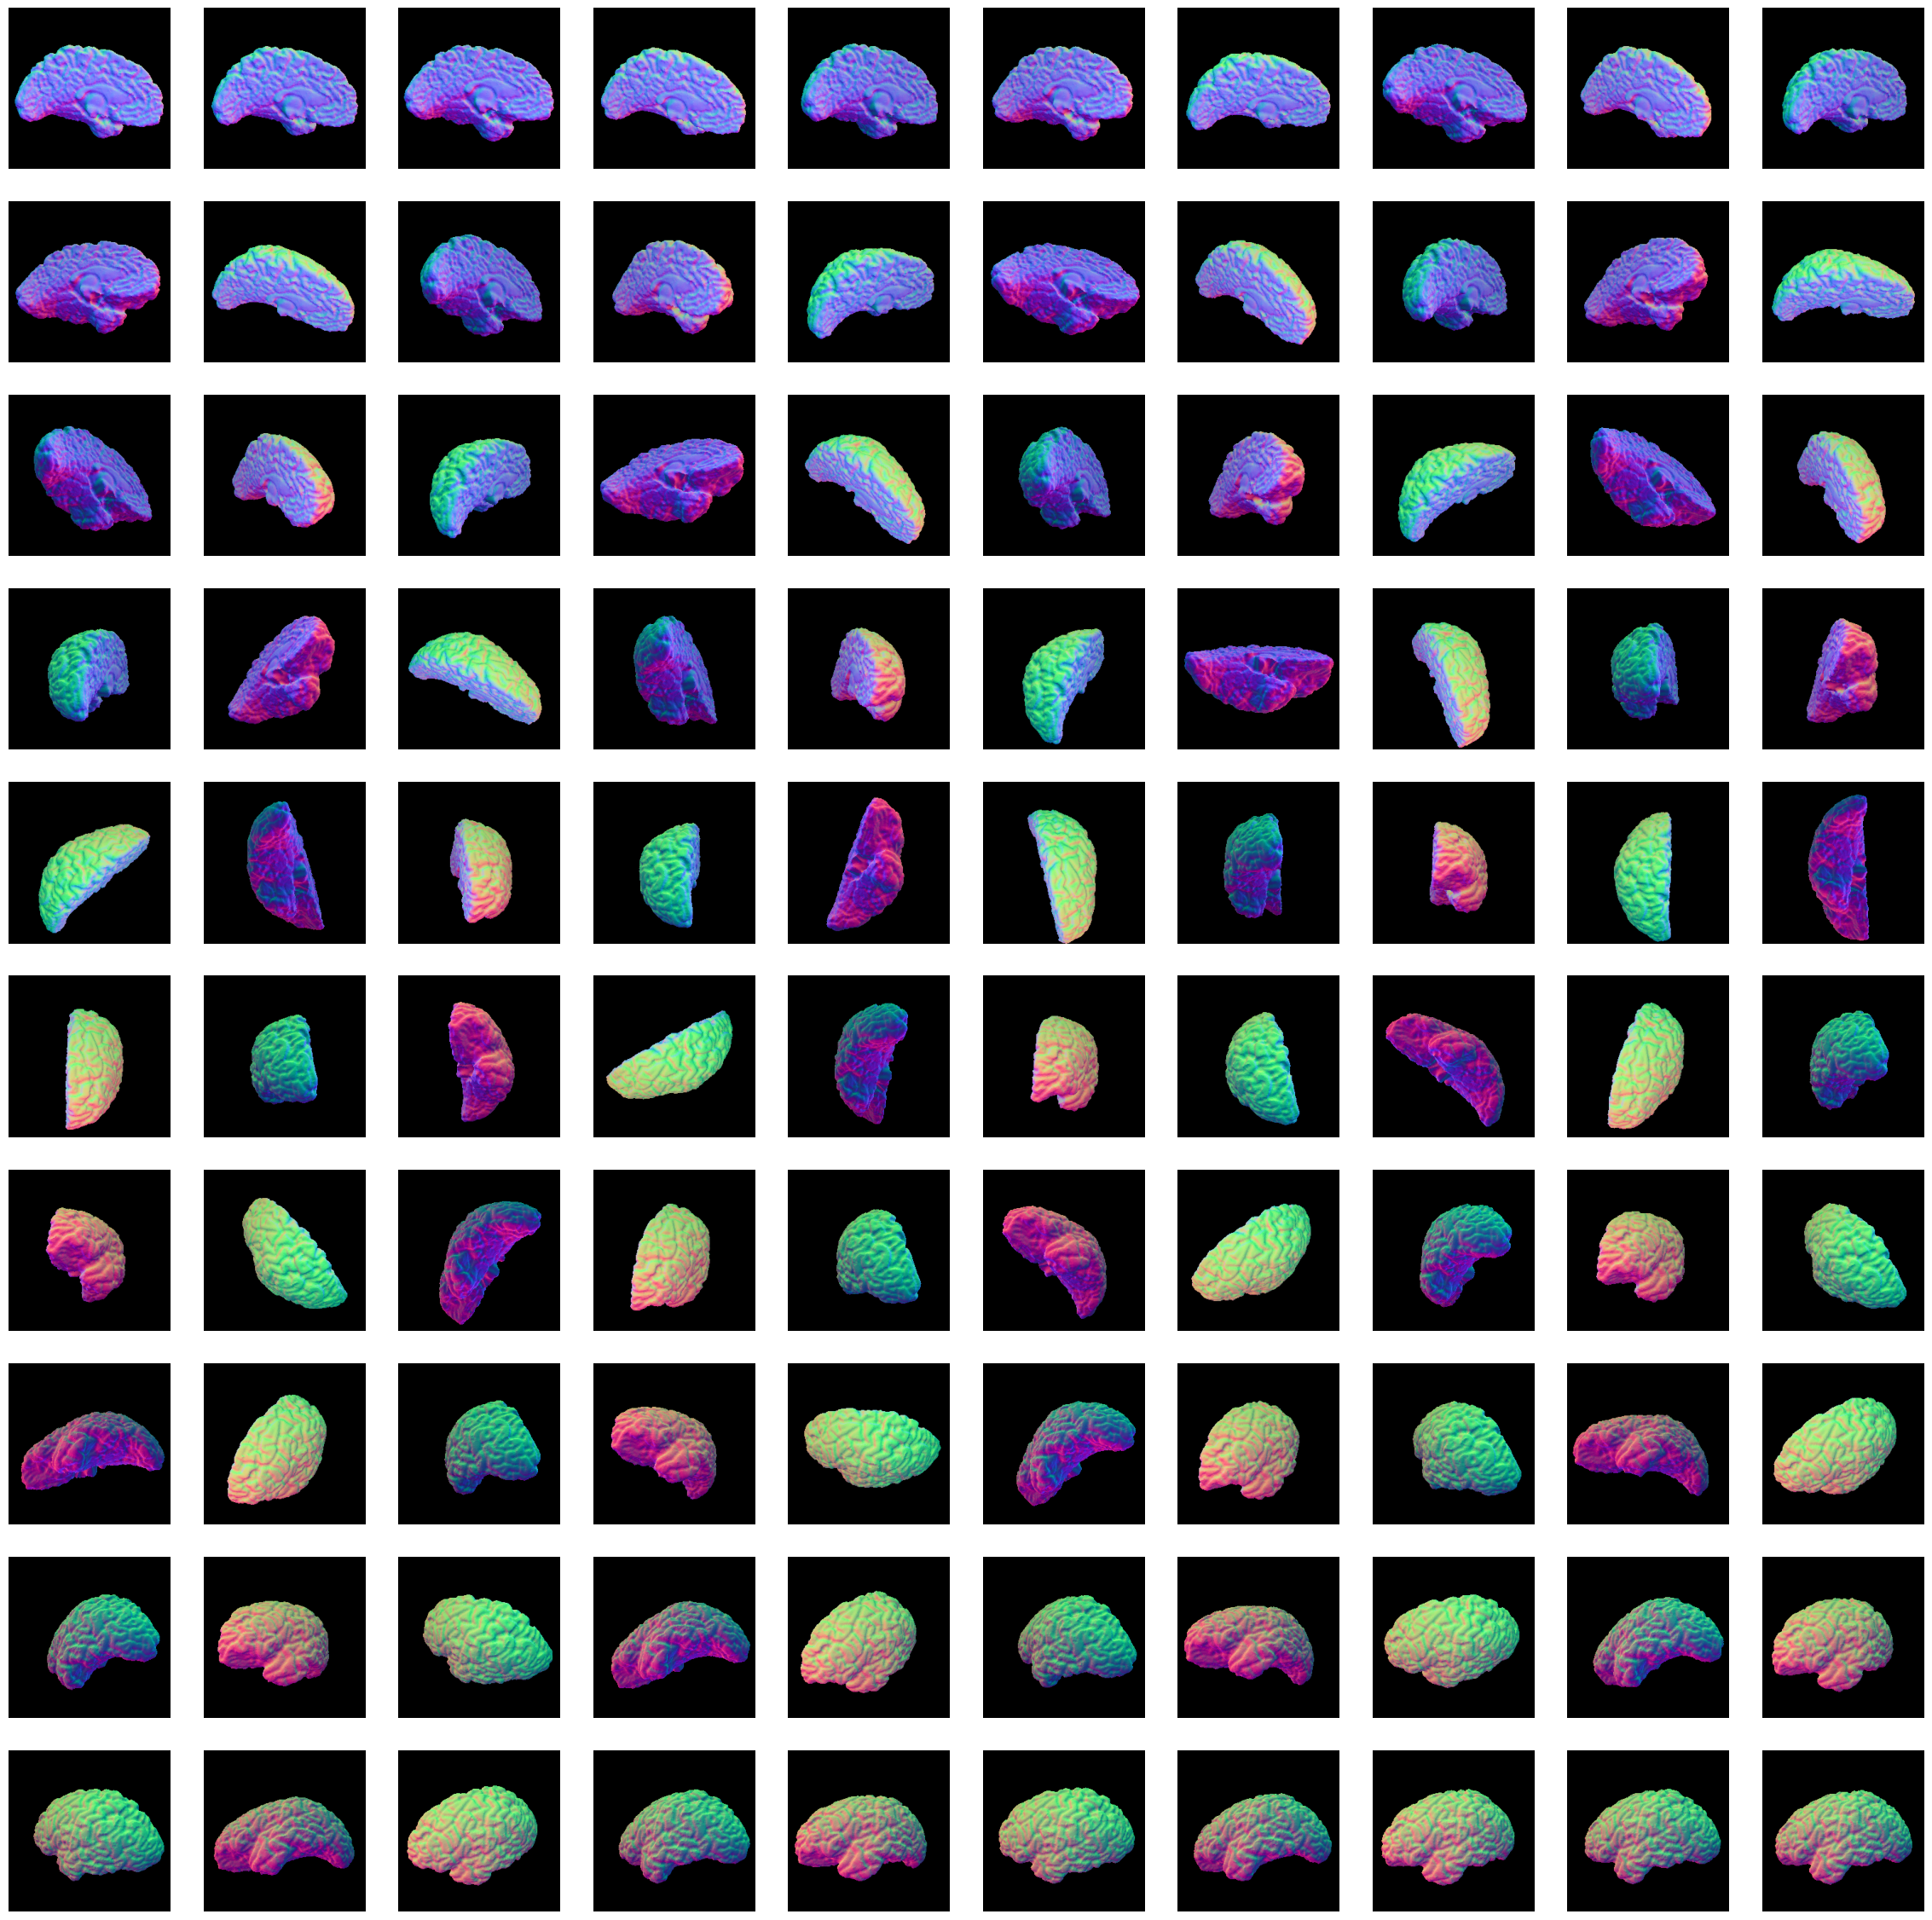

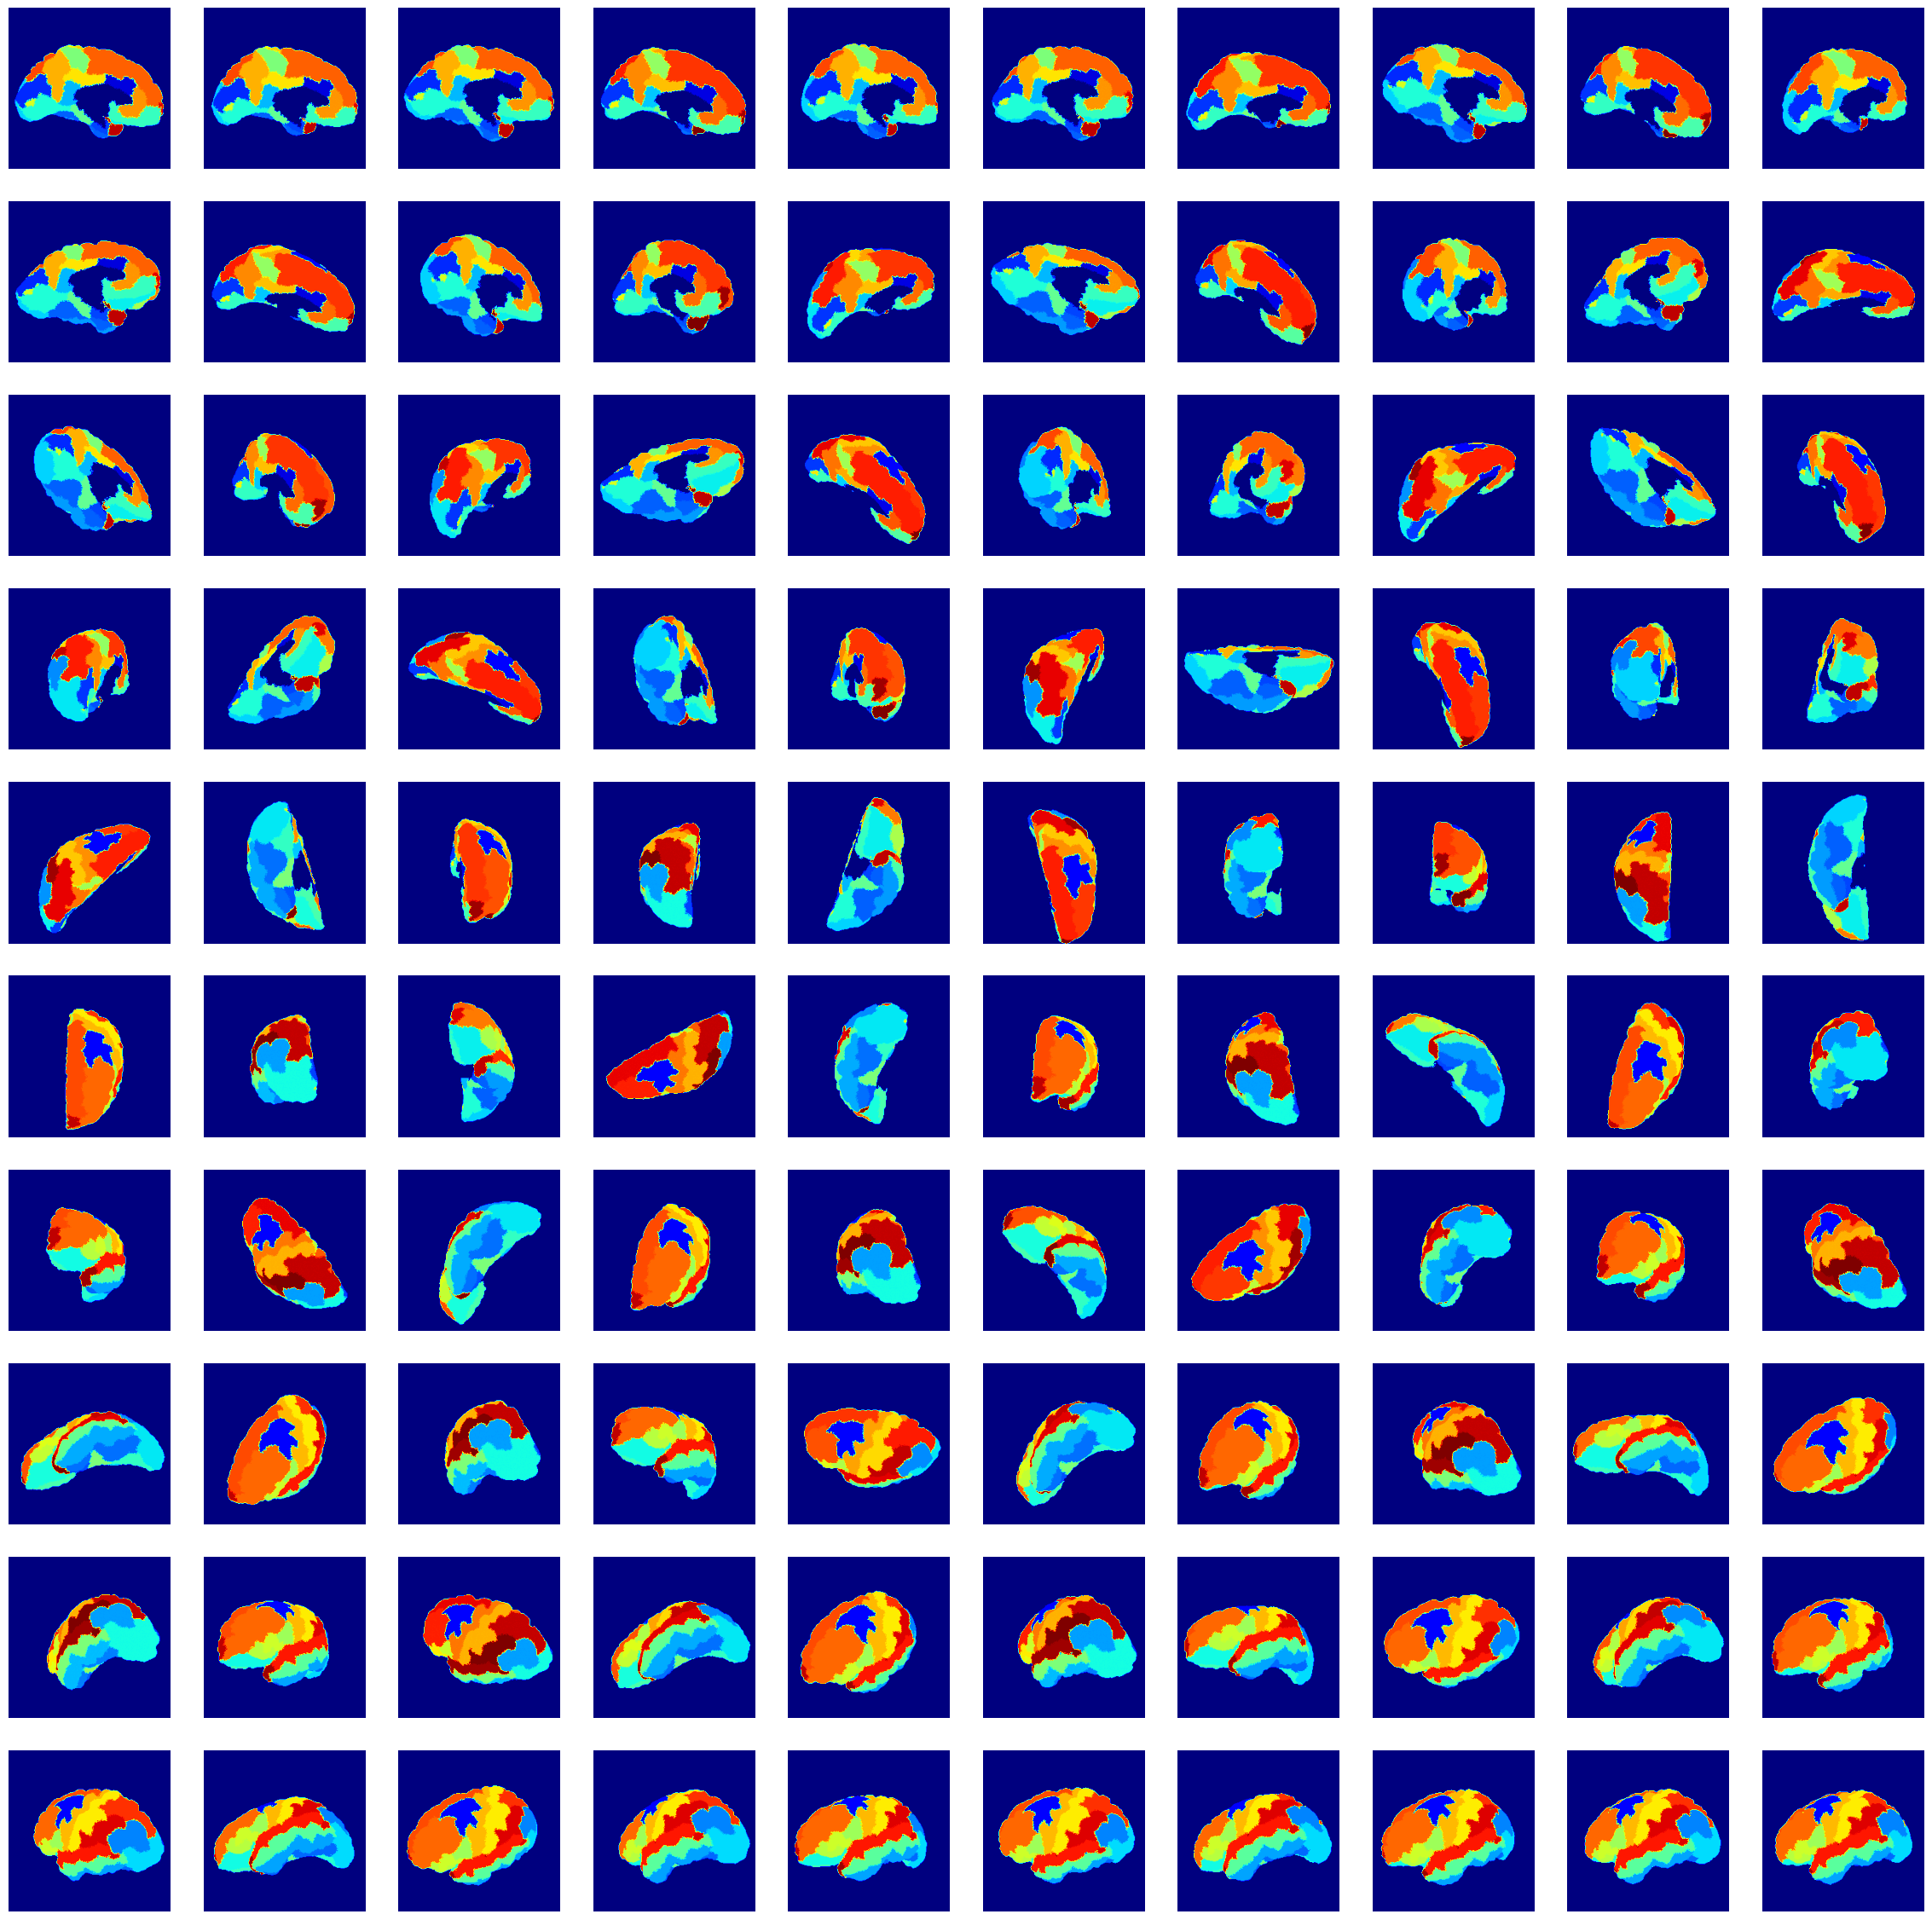

In [72]:
output_map, labels_map = get_projection(100206, fibonacci_sphere(100), width = 256, height = 256, visualize = True, w = 10, h = 10, zoom = 1.1)

In [73]:
class Data(Dataset):
    def __init__(self, output_map, labels_map):
        self.images = output_map
        self.masks = np.transpose(labels_map + 1, (2, 0, 1))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

In [74]:
data = Data(output_map, labels_map)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, pin_memory=True)

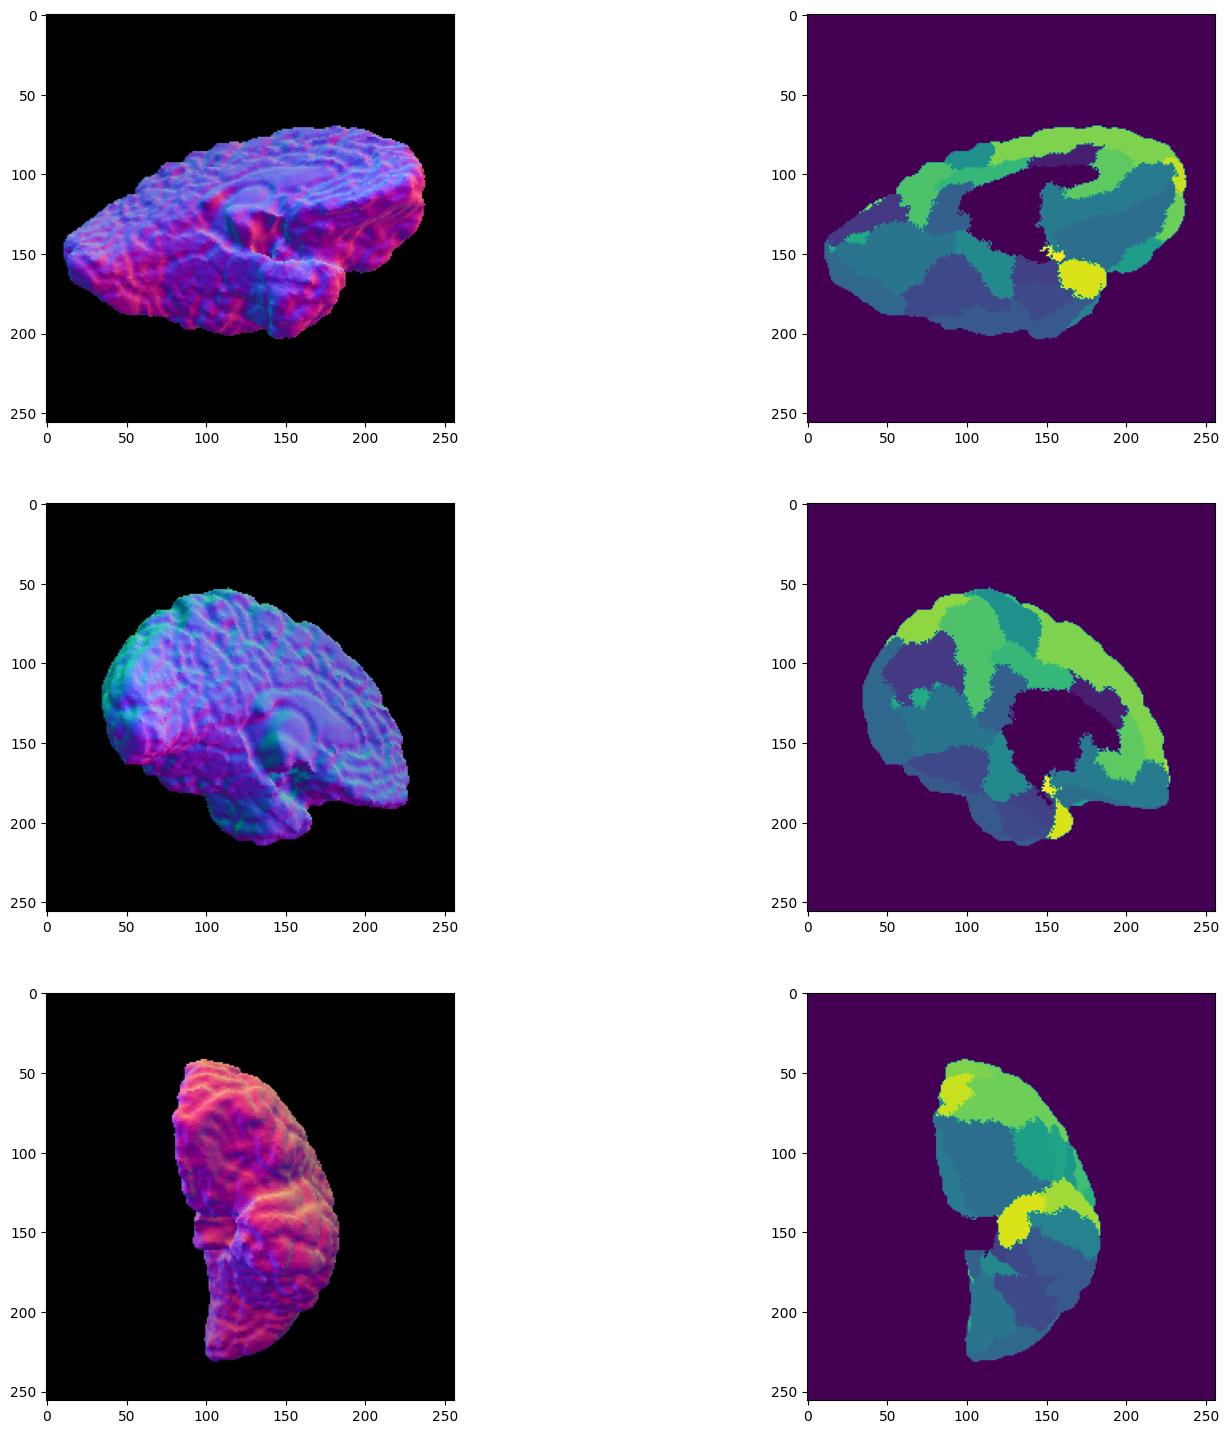

In [75]:
for img, mask in train_batch:
    img1 = np.transpose(img[0,:,:,:],(1, 2, 0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1, 2, 0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1, 2, 0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

In [76]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [77]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)    
    
class unet_model(nn.Module):
    def __init__(self,out_channels=37,features=[64, 128, 256, 512]):
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [78]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = unet_model().to(DEVICE)

In [84]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
    encoding_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [80]:
LEARNING_RATE = 1e-4
num_epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16004\3568018926.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [81]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16004\384509046.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[8, 256, 256, 3] to have 3 channels, but got 256 channels instead

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [ ]:
check_accuracy(train_batch, model)

In [ ]:
check_accuracy(test_batch, model)